In [5]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install mesa
!pip install batch_run

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.7/427.7 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 12.0 MB/s eta 0:0

In [14]:
# Importamos las clases que se requieren para manejar los agentes (Agent)
# y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Necesitamos varios agentes por celda celda, elegimos
# ''MultiGridd''.
from mesa.space import MultiGrid

# Con ''Random Activation, hacemos que todos los agentes se activen
# ''se activen aleatoriamente''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso
# de la simulación.
from mesa.datacollection import DataCollector

# Haremos uso de ''batch_run'' para ejecutar varias simulaciones
from mesa.batchrunner import batch_run
import matplotlib.patches as patches  # Importar para usar círculos

# matplotlib lo usaremos crear una animación de cada uno de los pasos
# del modelo.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores
# numéricos.
import numpy as np
import pandas as pd
import seaborn as sns

In [15]:
class robotAgent(Agent):
    """Un agente robot que acomoda cajas."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.cargandoCaja = 0
        self.steps = 0
        self.centrado = False

    def move(self):
        center_pos = (self.model.coordenadaPila[0],self.model.coordenadaPila[1])
        if self.cargandoCaja > 0:
            # Verificar si el centro está ocupado por otro agente
            if self.pos == tuple(center_pos) and self.cargandoCaja > 0:
                cell_agents = self.model.grid.get_cell_list_contents([center_pos])
                if len(cell_agents) == 1:  # Solo este agente está en el centro
                    cajas_restantes = self.model.depositar_caja(self.cargandoCaja)
                    self.cargandoCaja = cajas_restantes  # Vaciar la caja o almacenar las no depositadas
                    self.centrado = False
                else:
                    self.centrado = True  # Esperar hasta que el centro esté libre
            else:
                # Moverse hacia el centro
                self.centrado = True
                possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
                closest_step = min(possible_steps, key=lambda x: self.distance(x, center_pos))

                # Verificar si el paso más cercano está ocupado por otro agente
                cell_agents = self.model.grid.get_cell_list_contents([closest_step])
                if len(cell_agents) == 0:  # Si no hay agentes, moverse
                    self.model.grid.move_agent(self, closest_step)
        else:
            # Moverse a una celda vacía en el vecindario
            possible_steps = ()
            neighbor_cells = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False, radius=1)
            for neighbor_cell in neighbor_cells:
                cell_agents = self.model.grid.get_cell_list_contents([neighbor_cell])
                if len(cell_agents) == 0:  # Si no hay agentes en la celda vecina
                    possible_steps += (neighbor_cell,)
            if possible_steps:
                for neighbor_cell in neighbor_cells:
                    x, y = neighbor_cell
                    if self.model.celdas_ocupadas[x, y] == 1 and neighbor_cell!=center_pos:  # Verifica si la celda adyacente tiene exactamente 1 caja
                        self.model.celdas_ocupadas[x, y] = 0  #  andRecoger la caja
                        self.cargandoCaja += 1
                new_position = self.random.choice(possible_steps)
                self.model.grid.move_agent(self, new_position)
                self.steps += 1
            else:
                if(self.pos==center_pos):
                    print('Estoy encerrado en el centro, voy a hacer que todos se muevan para liberarme')
                    self.model.mover_agentes_abajo()
                else:
                    return

    def distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def step(self):
        self.move()

class CuartoModel(Model):
    """A model with some number of agents."""

    def __init__(self, porcentaje_ocupadas, N, width, height):
        super().__init__()
        self.pasos = 0
        self.cantidadPilas = 0
        self.cajasAcomodadas = 0  # Variable para llevar el conteo de cajas acomodadas
        self.grid = MultiGrid(width, height, False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={
                "AgentPositions": lambda m: [agent.pos for agent in m.schedule.agents],
                "CajaPositions": self.get_caja_positions,
                "Pasos": lambda m: m.pasos,
                "CajasAcomodadas": lambda m: m.cajasAcomodadas  # Recolectar datos de cajas acomodadas
            },
            agent_reporters={"Steps": "steps"}
        )
        # Inicializar la cantidad objetivo de pilas
        self.num_ocupadas = round(width*height*porcentaje_ocupadas)
        self.cantidadPilasObjetivo = round(self.num_ocupadas / 5)

        # Inicializar la coordenada de la pila
        self.coordenadaPila = [self.grid.width // 2, self.grid.height - 1]

        # Inicializar la matriz de celdas ocupadas
        self.celdas_ocupadas = np.zeros((width, height), dtype=int)
        todas_las_celdas = [(x, y) for x in range(width) for y in range(height)]
        celdas_ocupadas_indices = self.random.sample(todas_las_celdas, self.num_ocupadas)

        for (x, y) in celdas_ocupadas_indices:
            self.celdas_ocupadas[x, y] = 1

        # Crear robots
        for i in range(N):
            a = robotAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def get_caja_positions(self):
        """Devuelve un diccionario con las posiciones de las celdas ocupadas y la cantidad de cajas en cada una."""
        return self.celdas_ocupadas

    def mover_agentes_abajo(self):
        """Mueve todos los agentes un paso hacia abajo."""
        for agent in self.schedule.agents:
            if isinstance(agent, robotAgent):
                x, y = agent.pos
                new_y = y - 1
                # Asegúrate de que el nuevo movimiento esté dentro de los límites del grid
                if 0 <= new_y < self.grid.height:
                    new_pos = (x, new_y)
                    # Mueve el agente a la nueva posición si está disponible
                    if self.grid.is_cell_empty(new_pos):
                        self.grid.move_agent(agent, new_pos)

    def depositar_caja(self, cantidad):
        """Método para depositar las cajas en la coordenada definida."""
        espacio_disponible = 5 - self.celdas_ocupadas[self.coordenadaPila[0], self.coordenadaPila[1]]
        cantidad_a_depositar = min(cantidad, espacio_disponible)

        self.celdas_ocupadas[self.coordenadaPila[0], self.coordenadaPila[1]] += cantidad_a_depositar
        self.cajasAcomodadas += cantidad_a_depositar  # Actualizar el conteo de cajas acomodadas

        # Devolver cualquier caja no depositada al agente
        cantidad_restante = cantidad - cantidad_a_depositar

        # Si la pila llega a 5, cambiar de posición
        if self.celdas_ocupadas[self.coordenadaPila[0], self.coordenadaPila[1]] == 5:
            self.cantidadPilas += 1
            self.coordenadaPila[1] -= 1

        # Retornar la cantidad de cajas no depositadas al agente
        return cantidad_restante

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.pasos += 1
        if self.cantidadPilas == self.cantidadPilasObjetivo:
            self.running = False  # Detener el modelo cuando se alcanza la cantidad objetivo de pilas


In [16]:
# --- Run your model ---
porcentajeDeCajas = 0.25
numeroAgentes = 5
pasos = 6000
alturaGrid = 20
largoGrid = 20

model = CuartoModel(porcentajeDeCajas, numeroAgentes, alturaGrid, largoGrid)

step_count = 0
while model.running and step_count < pasos:
    model.step()
    step_count += 1

print("Numero de pasos que realizo la simulacion",step_count)


Numero de pasos que realizo la simulacion 3079


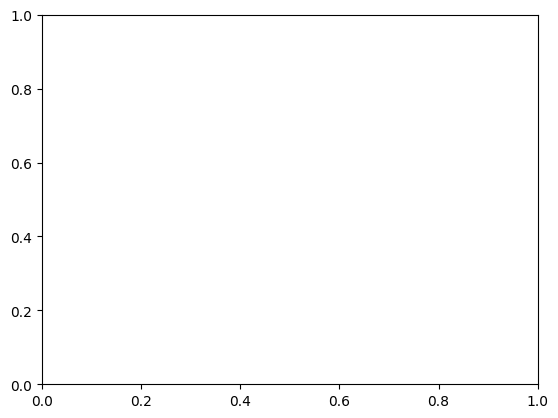

In [37]:
datacollector_df = model.datacollector.get_model_vars_dataframe()
num_steps = len(datacollector_df)
grids = []
for step in range(num_steps):
    agent_positions = datacollector_df.iloc[step]["AgentPositions"]
    celdas_ocupadas = datacollector_df.iloc[step]["CajaPositions"]
    grid = np.zeros((model.grid.width, model.grid.height), dtype=int)

    # Marcar número de basuras en cada celda
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            grid[x][y] = celdas_ocupadas[x, y]  # Copiar el número de basuras en la celda
    grids.append((grid, agent_positions))
# --- Update function for animation ---
def update(frame):
    ax.clear()  # Limpiar el eje para cada frame
    grid, agent_positions = grids[frame]

    # Dibujar la grid
    mat = ax.matshow(grid, cmap='YlOrBr', origin='lower')

    # Añadir el número de basuras en las celdas
    for (i, j), val in np.ndenumerate(grid):
        if val > 0:
            ax.text(j, i, f'{val}', ha='center', va='center', color='black')

    # Añadir los agentes
    for pos in agent_positions:
        x, y = pos
        circle = patches.Circle((y, x), radius=0.3, facecolor='green', edgecolor='black', linewidth=1)
        ax.add_patch(circle)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Robots step: {frame}")
    return [mat]

# --- Set up the plot ---
fig, ax = plt.subplots()
grid, _ = grids[0]  # Initialize with the first grid state

# --- Create the animation ---
ani = animation.FuncAnimation(fig, update, frames=num_steps, interval=100, repeat=False)
# --- Show the animation ---
plt.show()



In [46]:
ani

KeyboardInterrupt: 

In [17]:
params = {"porcentaje_ocupadas":0.25, "N":5,"width": 20, "height": 20, }

results = batch_run(
    CuartoModel,
    parameters=params,
    iterations=100,
    max_steps=5000,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Estoy encerrado en el centro, voy a hacer que todos se muevan para liberarme
Estoy encerrado en el centro, voy a hacer que todos se muevan para liberarme
Estoy encerrado en el centro, voy a hacer que todos se muevan para liberarme


In [11]:
results_df = pd.DataFrame(results)

# Calcular el número promedio de pasos para limpiar completamente la habitación (variable Pasos)
average_steps_pasos = results_df.groupby('RunId')['Pasos'].max().mean()

# Calcular el promedio de pasos por agente (variable Steps)
average_steps_steps = results_df['Steps'].mean()

# Mostrar los resultados
print(f"Promedio de 'Pasos' por simulación: {int(average_steps_pasos)}")
print(f"Promedio de 'Steps' por agente: {int(average_steps_steps)}")

Promedio de 'Pasos' por simulación: 2240
Promedio de 'Steps' por agente: 1090


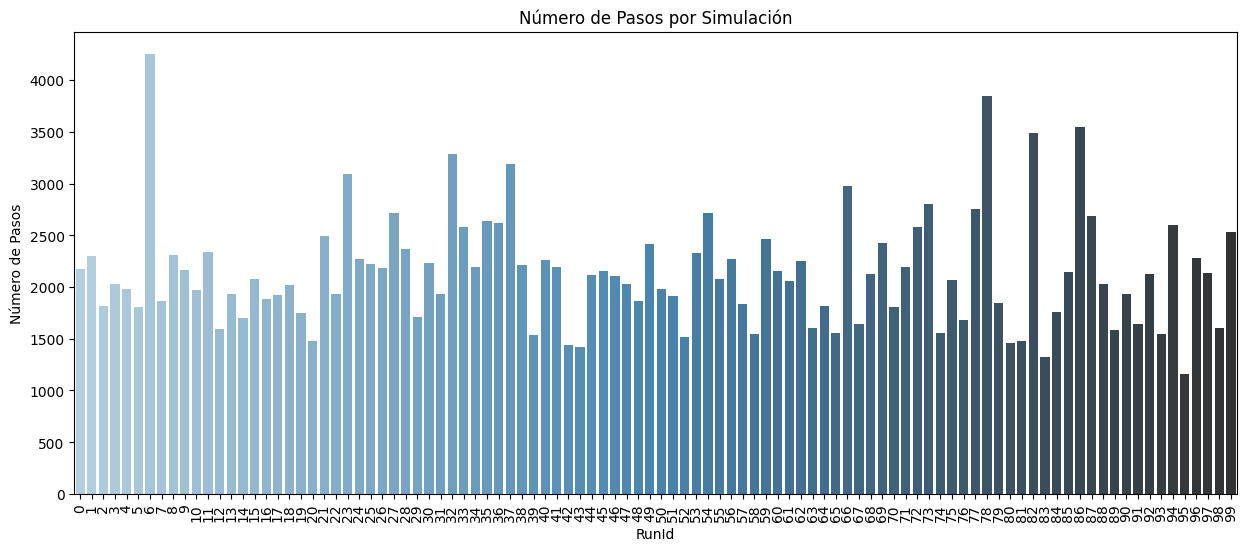

In [18]:
results_df = pd.DataFrame(results)

# Calcular el número promedio de pasos para limpiar completamente la habitación
average_steps = results_df.groupby('RunId')['Pasos'].max().mean()

steps_per_simulation = results_df.groupby('RunId')['Pasos'].max()
# Convertir a DataFrame para facilitar su manejo
steps_df = steps_per_simulation.reset_index()

# Mostrar los resultados
plt.figure(figsize=(15, 6))
sns.barplot(x='RunId', y='Pasos', data=steps_df, hue='RunId',palette='Blues_d',legend=False)

# Añadir títulos y etiquetas
plt.title('Número de Pasos por Simulación')
plt.xlabel('RunId')
plt.ylabel('Número de Pasos')

# Rotar las etiquetas del eje x para que sean verticales
plt.xticks(rotation=90)

# Mostrar la gráfica
plt.show()

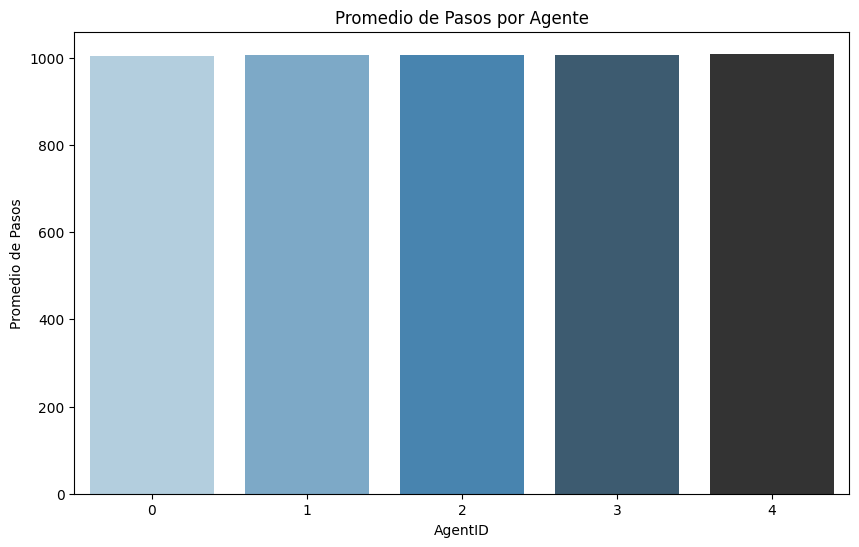

In [19]:
# Calcular el promedio de steps por AgentID
promedio_steps_por_agente = results_df.groupby('AgentID')['Steps'].mean().reset_index()

# Redondear el promedio si lo deseas
promedio_steps_por_agente['Steps'] = round(promedio_steps_por_agente['Steps'])

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='AgentID', y='Steps', data=promedio_steps_por_agente, hue='AgentID', palette='Blues_d', legend=False)

# Añadir títulos y etiquetas
plt.title('Promedio de Pasos por Agente')
plt.xlabel('AgentID')
plt.ylabel('Promedio de Pasos')

# Mostrar la gráfica
plt.show()